In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from accdb_reading import get_measure_df
from measurement_collector import MeasurementCollector
from tqdm import tqdm
import numpy as np

def plot_cm_keras(_model, _X_test, _y_test):
    predictions = _model.predict(_X_test)
    cm = confusion_matrix(_y_test.argmax(axis=1), predictions.argmax(axis=1), normalize="pred")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(_y_test.argmax(axis=1)))
    disp.plot()
    
_db_path = "/home/levcsi/projects/stroke_prediction/data/WUS-v4meresek 20220202.accdb"
_m_path = "/home/levcsi/projects/stroke_prediction/data/biocal.xlsx"
mc = MeasurementCollector('/home/levcsi/projects/stroke_prediction/data', _db_path, _m_path)

2022-03-08 14:46:33.210570: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/installation/OpenCV-3.4.4/lib/
2022-03-08 14:46:33.210684: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


202110230 is not found in aux data
202110230 measurement_path_dict is OK
202110251 measurement_path_dict is OK
202110280 measurement_path_dict is OK
202111021 measurement_path_dict is OK
202111041 measurement_path_dict is OK
202111141 measurement_path_dict is OK
202111181 measurement_path_dict is OK
202112020 measurement_path_dict is OK
202112131 measurement_path_dict is OK
202112171 measurement_path_dict is OK
202201061 measurement_path_dict is OK
202201191 measurement_path_dict is OK
202201310 measurement_path_dict is not full (it will be deleted)
202201310 is not valid (deleted)
Number of measurements 12
Number of 0: 4 (33.33 %)
Number of 1: 0 (0.00 %)
Number of 2: 4 (33.33 %)
Number of 3: 0 (0.00 %)
Number of 4: 1 (8.33 %)
Number of 5: 3 (25.00 %)


In [2]:
keys_in_order = (("arm", "acc"),
                 ("leg", "acc"),
                 ("arm", "gyr"),
                 ("leg", "gyr"))

length = 25 * 60 * 30
sample_size = 1000000

X = list()
y = list()
for _ in tqdm(range(sample_size)):
    random_diff_dict, class_value = mc.get_random_mean_with_class_all(mean_type='all',
                                                                      length=length)
    instance = list()
    for key in keys_in_order:
        instance.append(random_diff_dict[key])
    instance = sum(instance, [])
        
    X.append(instance)
    y.append(class_value)

100%|█████████████████████████████████████████████████████| 1000000/1000000 [23:28<00:00, 710.05it/s]


In [3]:
def define_model(inpit_shape):
    ip = Input(shape=(inpit_shape,), name="input")
    #x = Dense(units=1024, name="hiddel_layer", activation="relu")(ip)
    x = Dense(units=256, name="hiddel_layer_2", activation="relu")(ip)
    x = Dense(units=128, name="hiddel_layer_3", activation="relu")(x)
    op = Dense(units=6, name="prediction", activation="softmax")(x)
    model = Model(inputs=ip, outputs=op, name="full_model")
    model.summary()
    
    learning_rate = 0.001
    optimizer = Adam(learning_rate, amsgrad=True)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [4]:
y_cat = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y_cat),
                                                    test_size=0.3, stratify=y,
                                                    random_state=42)

In [6]:
callback = EarlyStopping(monitor='val_loss', patience=20)
model = define_model(X_train.shape[1])
history = model.fit(X_train,
                    y_train,
                    batch_size=100,
                    epochs=1500,
                    callbacks=[callback],
                    verbose=1,
                    validation_data=(X_test, y_test))

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 12)]              0         
                                                                 
 hiddel_layer_2 (Dense)      (None, 256)               3328      
                                                                 
 hiddel_layer_3 (Dense)      (None, 128)               32896     
                                                                 
 prediction (Dense)          (None, 6)                 774       
                                                                 
Total params: 36,998
Trainable params: 36,998
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
7000/7000 [==============================] - 18s 3ms/step - loss: 0.6282 - accuracy: 0.7341 - val_loss: 0.5728 - val_accuracy: 0.7613
Epoch 2/1500
7000/7000 [=============

7000/7000 [==============================] - 17s 2ms/step - loss: 0.3178 - accuracy: 0.8749 - val_loss: 0.3404 - val_accuracy: 0.8651
Epoch 51/1500
7000/7000 [==============================] - 19s 3ms/step - loss: 0.3175 - accuracy: 0.8748 - val_loss: 0.3357 - val_accuracy: 0.8669
Epoch 52/1500
7000/7000 [==============================] - 20s 3ms/step - loss: 0.3172 - accuracy: 0.8750 - val_loss: 0.3285 - val_accuracy: 0.8704
Epoch 53/1500
7000/7000 [==============================] - 17s 2ms/step - loss: 0.3165 - accuracy: 0.8751 - val_loss: 0.3275 - val_accuracy: 0.8712
Epoch 54/1500
7000/7000 [==============================] - 16s 2ms/step - loss: 0.3160 - accuracy: 0.8752 - val_loss: 0.3290 - val_accuracy: 0.8701
Epoch 55/1500
7000/7000 [==============================] - 16s 2ms/step - loss: 0.3155 - accuracy: 0.8755 - val_loss: 0.3290 - val_accuracy: 0.8701
Epoch 56/1500
7000/7000 [==============================] - 16s 2ms/step - loss: 0.3148 - accuracy: 0.8758 - val_loss: 0.3269 -

7000/7000 [==============================] - 16s 2ms/step - loss: 0.2972 - accuracy: 0.8836 - val_loss: 0.3155 - val_accuracy: 0.8766
Epoch 106/1500
7000/7000 [==============================] - 16s 2ms/step - loss: 0.2967 - accuracy: 0.8838 - val_loss: 0.3184 - val_accuracy: 0.8751
Epoch 107/1500
7000/7000 [==============================] - 16s 2ms/step - loss: 0.2967 - accuracy: 0.8838 - val_loss: 0.3162 - val_accuracy: 0.8760
Epoch 108/1500
7000/7000 [==============================] - 16s 2ms/step - loss: 0.2962 - accuracy: 0.8838 - val_loss: 0.3152 - val_accuracy: 0.8762
Epoch 109/1500
7000/7000 [==============================] - 16s 2ms/step - loss: 0.2962 - accuracy: 0.8839 - val_loss: 0.3167 - val_accuracy: 0.8757
Epoch 110/1500
7000/7000 [==============================] - 16s 2ms/step - loss: 0.2959 - accuracy: 0.8842 - val_loss: 0.3177 - val_accuracy: 0.8756
Epoch 111/1500
7000/7000 [==============================] - 16s 2ms/step - loss: 0.2957 - accuracy: 0.8838 - val_loss: 0.

7000/7000 [==============================] - 16s 2ms/step - loss: 0.2867 - accuracy: 0.8879 - val_loss: 0.3160 - val_accuracy: 0.8763
Epoch 161/1500
7000/7000 [==============================] - 19s 3ms/step - loss: 0.2863 - accuracy: 0.8880 - val_loss: 0.3133 - val_accuracy: 0.8778
Epoch 162/1500
7000/7000 [==============================] - 16s 2ms/step - loss: 0.2862 - accuracy: 0.8879 - val_loss: 0.3160 - val_accuracy: 0.8763
Epoch 163/1500
7000/7000 [==============================] - 16s 2ms/step - loss: 0.2862 - accuracy: 0.8880 - val_loss: 0.3230 - val_accuracy: 0.8739
Epoch 164/1500
7000/7000 [==============================] - 16s 2ms/step - loss: 0.2860 - accuracy: 0.8879 - val_loss: 0.3130 - val_accuracy: 0.8778
Epoch 165/1500
7000/7000 [==============================] - 16s 2ms/step - loss: 0.2858 - accuracy: 0.8877 - val_loss: 0.3133 - val_accuracy: 0.8782


Train accuracy: 0.8899442857142857
Test accuracy: 0.8781766666666667


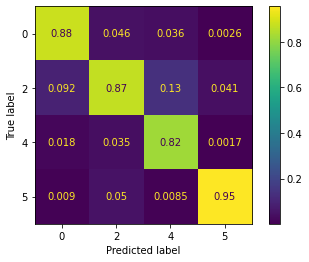

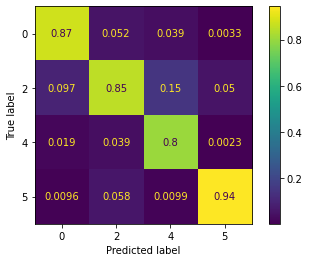

In [7]:
y_pred_train = model.predict(X_train)
print("Train accuracy: {}".format(accuracy_score(np.argmax(y_train, axis=1),
                                                 np.argmax(y_pred_train, axis=1))))
y_pred_test = model.predict(X_test)
print("Test accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1),
                                                np.argmax(y_pred_test, axis=1))))
plot_cm_keras(model, X_train, y_train)
plot_cm_keras(model, X_test, y_test)

In [8]:
model.save('./model_{}_{}'.format(length, sample_size))

2022-03-08 15:58:59.036324: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./model_45000_1000000/assets
